## 1、定义算法

在阅读该教程之前，请先阅读Q learning教程。Sarsa算法跟Q learning算法基本模式相同，但是根本的区别在于，Sarsa是先做出动作然后拿这个做的动作去更新，而Q learning是假定下一步最大奖励对应的动作拿去更新，然后再使用$\varepsilon$-greedy策略，也就是说Sarsa是on-policy的，而Q learning是off-policy的。如下方代码所示，只有在更新的地方Sarsa与Q learning有着细微的区别。

In [7]:
import numpy as np
from collections import defaultdict
import torch
import math
class Sarsa(object):
    def __init__(self,
                 n_actions,cfg):
        self.n_actions = n_actions  
        self.lr = cfg.lr  
        self.gamma = cfg.gamma  
        self.sample_count = 0 
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay 
        self.Q  = defaultdict(lambda: np.zeros(n_actions)) # Q table
    def sample(self, state):
        self.sample_count += 1
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) # The probability to select a random action, is is log decayed
        best_action = np.argmax(self.Q[state])
        action_probs = np.ones(self.n_actions, dtype=float) * self.epsilon / self.n_actions
        action_probs[best_action] += (1.0 - self.epsilon)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs) 
        return action
    def predict(self,state):
        return np.argmax(self.Q[state])
    def update(self, state, action, reward, next_state, next_action,done):
        Q_predict = self.Q[state][action]
        if done:
            Q_target = reward  # 终止状态
        else:
            Q_target = reward + self.gamma * self.Q[next_state][next_action] # 与Q learning不同，Sarsa是拿下一步动作对应的Q值去更新
        self.Q[state][action] += self.lr * (Q_target - Q_predict) 
    def save(self,path):
        '''把 Q表格 的数据保存到文件中
        '''
        import dill
        torch.save(
            obj=self.Q,
            f=path+"sarsa_model.pkl",
            pickle_module=dill
        )
    def load(self, path):
        '''从文件中读取数据到 Q表格
        '''
        import dill
        self.Q =torch.load(f=path+'sarsa_model.pkl',pickle_module=dill)

## 2、定义训练

同样地，跟Q learning差别也不大

In [8]:
def train(cfg,env,agent):
    print('开始训练！')
    print(f'环境:{cfg.env_name}, 算法:{cfg.algo_name}, 设备:{cfg.device}')
    rewards = []  # 记录奖励
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录每个回合的奖励
        state,info = env.reset()  # 重置环境,即开始新的回合
        action = agent.sample(state)
        while True:
            action = agent.sample(state)  # 根据算法采样一个动作
            next_state, reward, terminated, truncated, info = env.step(action)  # 与环境进行一次动作交互
            done=terminated or truncated
            
            next_action = agent.sample(next_state)
            agent.update(state, action, reward, next_state, next_action,done) # 算法更新
            state = next_state # 更新状态
            action = next_action
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.1f}，Epsilon：{agent.epsilon}")
    print('完成训练！')
    return {"rewards":rewards}
    
def test(cfg,env,agent):
    print('开始测试！')
    print(f'环境：{cfg.env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}')
    rewards = []  # 记录所有回合的奖励
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 记录每个episode的reward
        state,info = env.reset()  # 重置环境, 重新开一局（即开始新的一个回合）
        while True:
            action = agent.predict(state)  # 根据算法选择一个动作
            next_state, reward, terminated, truncated, info = env.step(action)  # 与环境进行一个交互
            done=terminated or truncated
            
            state = next_state  # 更新状态
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        print(f"回合数：{i_ep+1}/{cfg.test_eps}, 奖励：{ep_reward:.1f}")
    print('完成测试！')
    return {"rewards":rewards}

## 3、定义环境
为了具体看看Q learning和Sarsa的不同，笔者决定跟Q learning使用相同的环境


In [9]:
import gymnasium as gym
import turtle
import numpy as np

# turtle tutorial : https://docs.python.org/3.3/library/turtle.html

def GridWorld(gridmap=None, is_slippery=False):
    if gridmap is None:
        gridmap = ['SFFF', 'FHFH', 'FFFH', 'HFFG']
    env = gym.make("FrozenLake-v0", desc=gridmap, is_slippery=False)
    env = FrozenLakeWapper(env)
    return env


class FrozenLakeWapper(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.max_y = env.desc.shape[0]
        self.max_x = env.desc.shape[1]
        self.t = None
        self.unit = 50

    def draw_box(self, x, y, fillcolor='', line_color='gray'):
        self.t.up()
        self.t.goto(x * self.unit, y * self.unit)
        self.t.color(line_color)
        self.t.fillcolor(fillcolor)
        self.t.setheading(90)
        self.t.down()
        self.t.begin_fill()
        for _ in range(4):
            self.t.forward(self.unit)
            self.t.right(90)
        self.t.end_fill()

    def move_player(self, x, y):
        self.t.up()
        self.t.setheading(90)
        self.t.fillcolor('red')
        self.t.goto((x + 0.5) * self.unit, (y + 0.5) * self.unit)

    def render(self):
        if self.t == None:
            self.t = turtle.Turtle()
            self.wn = turtle.Screen()
            self.wn.setup(self.unit * self.max_x + 100,
                          self.unit * self.max_y + 100)
            self.wn.setworldcoordinates(0, 0, self.unit * self.max_x,
                                        self.unit * self.max_y)
            self.t.shape('circle')
            self.t.width(2)
            self.t.speed(0)
            self.t.color('gray')
            for i in range(self.desc.shape[0]):
                for j in range(self.desc.shape[1]):
                    x = j
                    y = self.max_y - 1 - i
                    if self.desc[i][j] == b'S':  # Start
                        self.draw_box(x, y, 'white')
                    elif self.desc[i][j] == b'F':  # Frozen ice
                        self.draw_box(x, y, 'white')
                    elif self.desc[i][j] == b'G':  # Goal
                        self.draw_box(x, y, 'yellow')
                    elif self.desc[i][j] == b'H':  # Hole
                        self.draw_box(x, y, 'black')
                    else:
                        self.draw_box(x, y, 'white')
            self.t.shape('turtle')

        x_pos = self.s % self.max_x
        y_pos = self.max_y - 1 - int(self.s / self.max_x)
        self.move_player(x_pos, y_pos)


class CliffWalkingWapper(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.t = None
        self.unit = 50
        self.max_x = 12
        self.max_y = 4

    def draw_x_line(self, y, x0, x1, color='gray'):
        assert x1 > x0
        self.t.color(color)
        self.t.setheading(0)
        self.t.up()
        self.t.goto(x0, y)
        self.t.down()
        self.t.forward(x1 - x0)

    def draw_y_line(self, x, y0, y1, color='gray'):
        assert y1 > y0
        self.t.color(color)
        self.t.setheading(90)
        self.t.up()
        self.t.goto(x, y0)
        self.t.down()
        self.t.forward(y1 - y0)

    def draw_box(self, x, y, fillcolor='', line_color='gray'):
        self.t.up()
        self.t.goto(x * self.unit, y * self.unit)
        self.t.color(line_color)
        self.t.fillcolor(fillcolor)
        self.t.setheading(90)
        self.t.down()
        self.t.begin_fill()
        for i in range(4):
            self.t.forward(self.unit)
            self.t.right(90)
        self.t.end_fill()

    def move_player(self, x, y):
        self.t.up()
        self.t.setheading(90)
        self.t.fillcolor('red')
        self.t.goto((x + 0.5) * self.unit, (y + 0.5) * self.unit)

    def render(self):
        if self.t == None:
            self.t = turtle.Turtle()
            self.wn = turtle.Screen()
            self.wn.setup(self.unit * self.max_x + 100,
                          self.unit * self.max_y + 100)
            self.wn.setworldcoordinates(0, 0, self.unit * self.max_x,
                                        self.unit * self.max_y)
            self.t.shape('circle')
            self.t.width(2)
            self.t.speed(0)
            self.t.color('gray')
            for _ in range(2):
                self.t.forward(self.max_x * self.unit)
                self.t.left(90)
                self.t.forward(self.max_y * self.unit)
                self.t.left(90)
            for i in range(1, self.max_y):
                self.draw_x_line(
                    y=i * self.unit, x0=0, x1=self.max_x * self.unit)
            for i in range(1, self.max_x):
                self.draw_y_line(
                    x=i * self.unit, y0=0, y1=self.max_y * self.unit)

            for i in range(1, self.max_x - 1):
                self.draw_box(i, 0, 'black')
            self.draw_box(self.max_x - 1, 0, 'yellow')
            self.t.shape('turtle')

        x_pos = self.s % self.max_x
        y_pos = self.max_y - 1 - int(self.s / self.max_x)
        self.move_player(x_pos, y_pos)

In [10]:
def env_agent_config(cfg,seed=1):
    '''创建环境和智能体
    Args:
        cfg ([type]): [description]
        seed (int, optional): 随机种子. Defaults to 1.
    Returns:
        env [type]: 环境
        agent : 智能体
    '''    
    env = gym.make(cfg.env_name)  
    env = CliffWalkingWapper(env)

    n_states = env.observation_space.n # 状态维度
    n_actions = env.action_space.n # 动作维度
    print(f"状态数：{n_states}，动作数：{n_actions}")
    agent = Sarsa(n_actions,cfg)
    return env,agent

## 4、设置参数
同样的参数也是一样

In [11]:
import datetime
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
def get_args():
    """ 
    """
    curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # 获取当前时间
    parser = argparse.ArgumentParser(description="hyperparameters")      
    parser.add_argument('--algo_name',default='Sarsa',type=str,help="name of algorithm")
    parser.add_argument('--env_name',default='CliffWalking-v0',type=str,help="name of environment")
    parser.add_argument('--train_eps',default=400,type=int,help="episodes of training") # 训练的回合数
    parser.add_argument('--test_eps',default=20,type=int,help="episodes of testing") # 测试的回合数
    parser.add_argument('--gamma',default=0.90,type=float,help="discounted factor") # 折扣因子
    parser.add_argument('--epsilon_start',default=0.95,type=float,help="initial value of epsilon") #  e-greedy策略中初始epsilon
    parser.add_argument('--epsilon_end',default=0.01,type=float,help="final value of epsilon") # e-greedy策略中的终止epsilon
    parser.add_argument('--epsilon_decay',default=300,type=int,help="decay rate of epsilon") # e-greedy策略中epsilon的衰减率
    parser.add_argument('--lr',default=0.1,type=float,help="learning rate")
    parser.add_argument('--device',default='cpu',type=str,help="cpu or cuda")          
    args = parser.parse_args([])                          
    return args

def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth

    Args:
        data (List):输入数据
        weight (Float): 平滑权重，处于0-1之间，数值越高说明越平滑，一般取0.9

    Returns:
        smoothed (List): 平滑后的数据
    '''
    last = data[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,cfg, tag='train'):
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{tag}ing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()
    plt.show()

## 5、开始训练
训练结果会发现，Sarsa收敛速度更快，但收敛值会比Q-learning低

状态数：48，动作数：4
开始训练！
环境:CliffWalking-v0, 算法:Sarsa, 设备:cpu
回合：1/400，奖励：-1203.0，Epsilon：0.07049414248565813
回合：2/400，奖励：-1066.0，Epsilon：0.01133983509362487
回合：3/400，奖励：-180.0，Epsilon：0.010402207645991594
回合：4/400，奖励：-194.0，Epsilon：0.01010998036181645
回合：5/400，奖励：-260.0，Epsilon：0.010019368250519155
回合：6/400，奖励：-53.0，Epsilon：0.010013557887585268
回合：7/400，奖励：-232.0，Epsilon：0.010002877634169344
回合：8/400，奖励：-138.0，Epsilon：0.01000114297573372
回合：9/400，奖励：-132.0，Epsilon：0.010000472509144364
回合：10/400，奖励：-137.0，Epsilon：0.010000188932618049
回合：11/400，奖励：-293.0，Epsilon：0.010000051662065352
回合：12/400，奖励：-203.0，Epsilon：0.010000013303898332
回合：13/400，奖励：-96.0，Epsilon：0.010000006991700247
回合：14/400，奖励：-28.0，Epsilon：0.01000000578185038
回合：15/400，奖励：-157.0，Epsilon：0.010000002023287708
回合：16/400，奖励：-125.0，Epsilon：0.010000000876391036
回合：17/400，奖励：-51.0，Epsilon：0.010000000621713296
回合：18/400，奖励：-200.0，Epsilon：0.010000000316022174
回合：19/400，奖励：-242.0，Epsilon：0.010000000121406658
回合：20/400，奖励：-63.0，Epsilon：0.

回合：291/400，奖励：-13.0，Epsilon：0.01
回合：292/400，奖励：-13.0，Epsilon：0.01
回合：293/400，奖励：-13.0，Epsilon：0.01
回合：294/400，奖励：-13.0，Epsilon：0.01
回合：295/400，奖励：-13.0，Epsilon：0.01
回合：296/400，奖励：-13.0，Epsilon：0.01
回合：297/400，奖励：-13.0，Epsilon：0.01
回合：298/400，奖励：-13.0，Epsilon：0.01
回合：299/400，奖励：-13.0，Epsilon：0.01
回合：300/400，奖励：-13.0，Epsilon：0.01
回合：301/400，奖励：-13.0，Epsilon：0.01
回合：302/400，奖励：-113.0，Epsilon：0.01
回合：303/400，奖励：-13.0，Epsilon：0.01
回合：304/400，奖励：-13.0，Epsilon：0.01
回合：305/400，奖励：-13.0，Epsilon：0.01
回合：306/400，奖励：-13.0，Epsilon：0.01
回合：307/400，奖励：-13.0，Epsilon：0.01
回合：308/400，奖励：-21.0，Epsilon：0.01
回合：309/400，奖励：-27.0，Epsilon：0.01
回合：310/400，奖励：-15.0，Epsilon：0.01
回合：311/400，奖励：-16.0，Epsilon：0.01
回合：312/400，奖励：-17.0，Epsilon：0.01
回合：313/400，奖励：-15.0，Epsilon：0.01
回合：314/400，奖励：-15.0，Epsilon：0.01
回合：315/400，奖励：-18.0，Epsilon：0.01
回合：316/400，奖励：-19.0，Epsilon：0.01
回合：317/400，奖励：-17.0，Epsilon：0.01
回合：318/400，奖励：-15.0，Epsilon：0.01
回合：319/400，奖励：-20.0，Epsilon：0.01
回合：320/400，奖励：-20.0，Epsilon：0.01
回合：321/40

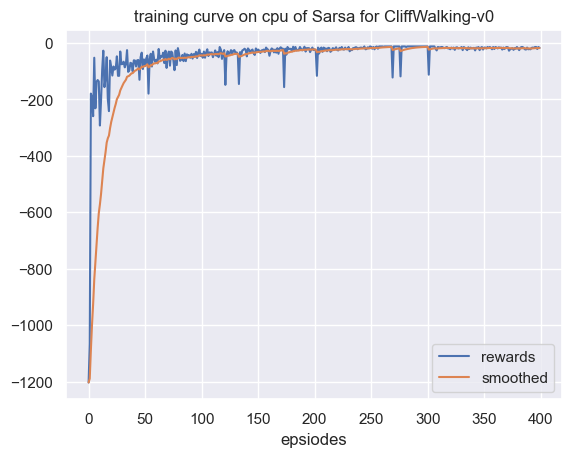

开始测试！
环境：CliffWalking-v0, 算法：Sarsa, 设备：cpu


In [ ]:
# 获取参数
cfg = get_args() 
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], cfg, tag="train")  
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], cfg, tag="test")  # 画出结果